In [64]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()
colors = ["#F26035", "#0071BC", "#009B55", "#F282B4"]
sns.set_palette(sns.color_palette(colors))
plt.tight_layout()
plt.rcParams["font.family"] = "CMU Sans Serif"

<Figure size 640x480 with 0 Axes>

Read in the examples that were used to weight the generator.

In [65]:
dir = "json"
examples = []
for file in os.listdir(dir):
    with open(dir + "/" + file, "r") as f:
        examples.append(f.read())

with open("unweighted.json", "r") as f:
    unweighted = f.readlines()

with open("weighted.json", "r") as f:
    weighted = f.readlines()

These examples are between ~200B and ~1KB, or between 236 and 1222 characters.

In [66]:
print("Example lengths (bytes/characters): ", sorted([len(e) for e in examples]))

Example lengths (bytes/characters):  [236, 289, 321, 408, 429, 879, 883, 883, 1222, 1222]


The following function reads a file full of generated JSON blobs and plots their lengths.

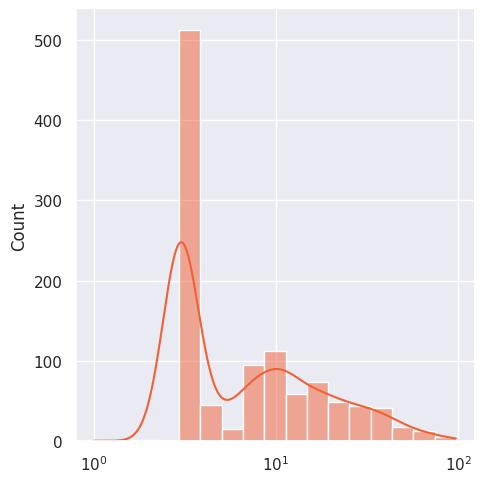

In [67]:
sns.displot(data=[len(s) for s in unweighted], kde=True, log_scale=True)
plt.savefig("unweighted_lengths.pdf")

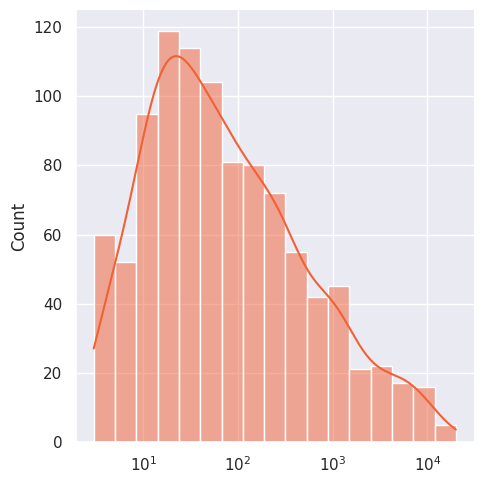

In [68]:
sns.displot(data=[len(s) for s in weighted], kde=True, log_scale=True)
plt.savefig("weighted_lengths.pdf")

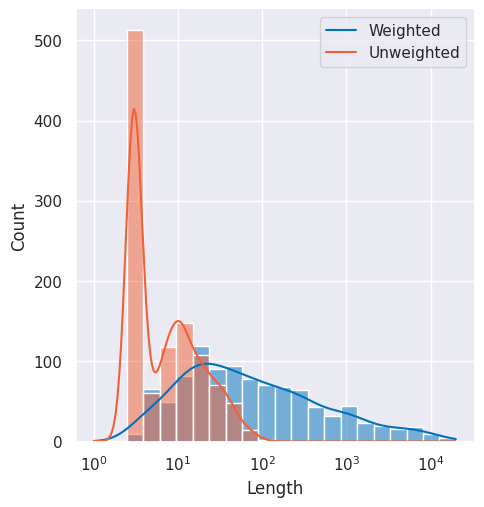

In [73]:
sns.displot(data=[[len(s) for s in unweighted], [len(s) for s in weighted]], kde=True, log_scale=True, legend=False)
plt.legend(labels=["Weighted", "Unweighted"])
plt.xlabel("Length")
plt.savefig("json_lengths.pdf")

The weighted generator has a much more interesting distribution of weights; the unweighted one leans
heavily towards short, uninteresting inputs. (The spike on the unweighted graph is length 2, which
is either `[]` or `{}`.)

To understand how similar or different the generated values are from the examples, we also compare
the distributions of characters present in their representations.

We compute the average _Jensen-Shannon Divergence_ between the letter distributions of each sample
and the examples. This divergence is sensible (and preferable to KL-divergence) because it correctly
handles distributions with differing support.

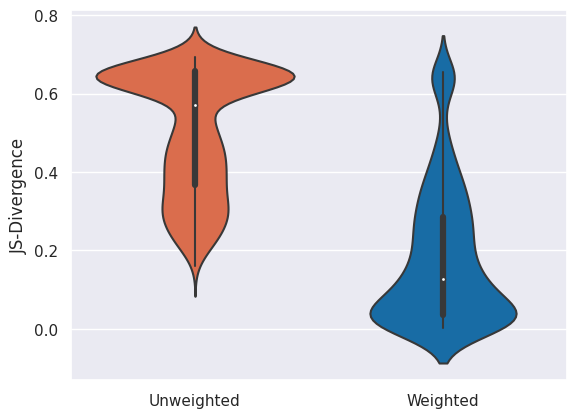

In [72]:
def letter_dist(s):
    m = {}
    for c in s:
        m[c] = m.get(c, 0) + 1
    total = sum(m.values())
    for c in m:
        m[c] /= total
    return m

def kl_divergence(p, q):
    return sum([p[c] * np.log(p[c] / q[c]) for c in q if c in p])

def jensen_shannon(p, q):
    m = {}
    for c in p | q:
        m[c] = (p.get(c, 0) + q.get(c, 0)) / 2
    return (kl_divergence(p, m) + kl_divergence(q, m)) / 2

exs = letter_dist("".join(examples))
unweighted_divs = [jensen_shannon(exs, letter_dist(s)) for s in unweighted]
weighted_divs = [jensen_shannon(exs, letter_dist(s)) for s in weighted]

data = pd.DataFrame(
    [["Unweighted", d] for d in unweighted_divs] +
    [["Weighted", d] for d in weighted_divs]
)
data.columns = ["label", "divergence"]

sns.violinplot(data=data, x="label", y="divergence")
plt.xlabel("")
plt.ylabel("JS-Divergence")
plt.savefig("js_divergence.pdf")

As desired, the weighted distribution tends to be much closer to the examples (lower divergence)
whereas the unweighted distribution is higher.